In [1]:
import librosa

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [4]:
# load the model from checkpoint
gen = tf.keras.models.load_model("./checkpoints/gen_norm2.h5")

In [5]:
def convert_audio(path):
    # load audio 16khz
    song,sr = librosa.load(path,sr=16000)
    stft = librosa.stft(np.asarray(song), n_fft=512, win_length=512, hop_length=256, window='hamming')
    spectrogram = np.abs(stft)
    phase = np.angle(stft)
    spectrogram = librosa.amplitude_to_db(spectrogram)
    max = np.max(spectrogram)
    min = np.min(spectrogram)
    # use min max scaling to make the data between [-1,+1]
    spectrogram = (spectrogram - min) / (max - min)
    

    # divide the spectrogram in patches of 32 columns each
    DIM = 32
    PTS = spectrogram.shape[1]//DIM
    lb = []
    hb = []
    for i in range(PTS):
        lb.append([spectrogram[:129,i*DIM:(i+1)*DIM]])
        hb.append([spectrogram[129:,i*DIM:(i+1)*DIM]])
    # reshape to N x 32 x 129, where N is the number of patches
    lb = np.array(lb).reshape(-1,32,129)
    hb = np.array(hb).reshape(-1,32,128)
    
    return lb,hb,spectrogram,phase,max,min

In [7]:
# test file
lr,hr,spectrogram,phase,MAX,MIN = convert_audio("./data/000002.mp3")

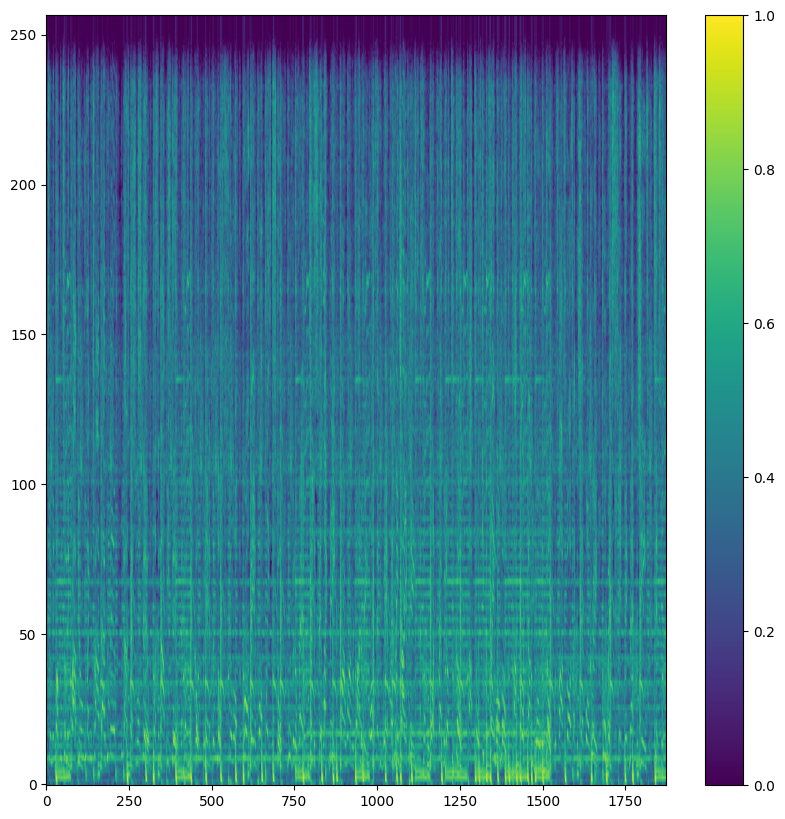

In [16]:
# display the original spectrogram
plt.figure(figsize=(10, 10))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

In [10]:
# reconstruct high frequencies
fake_hr = gen.predict(lr)

2023-02-13 19:17:06.551009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 49ms/step


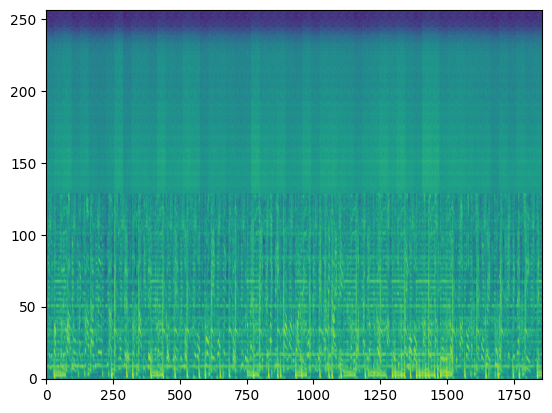

In [14]:
concat = np.concatenate((lr[0].reshape(129,32),fake_hr[0].reshape(128,32)),axis=0)

ret = []
for i in range(lr.shape[0]):
    concat = np.concatenate((lr[i].reshape(129,32),fake_hr[i].reshape(128,32)),axis=0)
    ret.append(concat)
ret = np.array(ret)
ret.shape


# concat the patches in ret into a single spectrogram
spectrogram_sr = np.concatenate(ret,axis=1)

plt.imshow(spectrogram_sr, aspect='auto', origin='lower')